In [1]:
import torch 
import torch.nn as nn 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import os 
from torchvision.io import read_image
import argparse
import os
import random
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.datasets import ImageFolder
from torch.optim import Adam

In [2]:
# Root directory for dataset
root_dir = r'/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/Splitted data by era - GAN project/test_iron'

# Number of workers for dataloader. (4 * nr_gpus)
workers = (4 * 1)

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

batch_size = 128

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Device: ", device)

Device:  cuda:0


In [3]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images to 64x64
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

dataset = ImageFolder(root=root_dir, transform=transform)

data_loader = DataLoader(dataset, batch_size, shuffle = True)

for images, labels in data_loader:
    print(images.shape)  # Print the shape of the images batch
    print(labels)  # Print the labels for the images
    break  # Only print the first batch for demonstration


class_to_idx = dataset.class_to_idx

# Print the mapping of class names to labels
print(class_to_idx)


torch.Size([128, 3, 64, 64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
{'iron': 0}


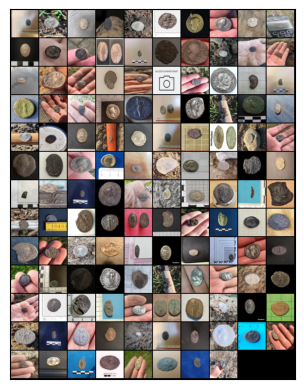

In [4]:
def show_image_grid(images: torch.Tensor, ncol: int): 
    image_grid = make_grid(
        images, 
        ncol
    ) # Make images into a grid 

    image_grid = image_grid.permute(1, 2, 0) # Move channel to the last 
    image_grid = image_grid.cpu().numpy() 

    plt.imshow(image_grid)
    plt.xticks([]) # Empty x and y labels 
    plt.yticks([])
    plt.show() 


show_image_grid(
    images = images, 
    ncol = 10
)

In [31]:
n_channels = 3 # RGB

def calc_output_layer_size_conv(input_size, kernel_size, padding, stride) -> int:
# Convolution Output Size = 1 + (Input Size - Filter size + 2 * Padding) / Stride
    output_size = 1 + (input_size - kernel_size + 2 * padding) / stride
    return int(output_size)

def calc_output_layer_size_transpose_conv(input_size, kernel_size, padding, stride, output_padding) -> int:
# OUTPUT DIMENSIONS: Transpose Convolution Output Size = (Input Size - 1) * Strides + Filter Size - 2 * Padding + Ouput Padding
    output_size = (input_size - 1) * stride + kernel_size - 2 * padding + output_padding
    if output_size < 1: 
        print("The size is not correct: ", output_size)
    else: 
        return int(output_size) 

class D(nn.Module):
    def __init__(
        self,
        hyperparams: dict 
    ): 
        super(D, self).__init__()

        num_layers = hyperparams['num_layers']
        kernel_size = hyperparams['kernel_size']
        padding = hyperparams['padding']
        stride = hyperparams['stride']
        
        self.layers = nn.ModuleList() 

        # Dynamically add more layers 
        for i in range(num_layers):
            kernel_size_val = kernel_size
            padding_val = padding
            stride_val = stride

            print(f"NUM LAYERS SIZE: {num_layers}")
            print(f"KERNEL SIZE: {kernel_size_val}")
            print(f"PADDING SIZE: {padding_val}")
            print(f"STRIDE SIZE: {stride_val}")
            
            self.layers.append(
                nn.Conv2d(
                    in_channels = in_channels,
                    out_channels = out_channels_layer,
                    kernel_size = kernel_size_val,
                    padding = padding_val,
                    stride = stride_val,
                    bias = False
                )
            )
            self.layers.append(
                nn.BatchNorm2d(
                    out_channels_layer
                )
            )
            self.layers.append(
                nn.LeakyReLU(
                    inplace = True, # Modify current tensor without creating intermediate tensors i.e. save memory
                    negative_slope = 0.2 # TODO: MIGHT ADD TO HYPERPARAMETERS! 
                )
            )
            final_channel = out_channels_layer
            final_kernel = kernel_size_val
            final_stride = stride_val
            final_padding = padding_val

        # Add final layer 
        self.layers.append(
            nn.Conv2d(
                in_channels = final_channel,
                out_channels = 1, # Final feature map
                kernel_size = final_kernel,
                padding = final_padding,
                stride = final_stride,
                bias = False
            )
        )
        self.layers.append(
            nn.Sigmoid()
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x



class G(nn.Module):
    def __init__(
        self,
        hyperparams: dict,
        general_hyperparams,
        num_layers,
        test: bool
    ): 
        super(G, self).__init__()

        self.test = test

        self.num_layers = num_layers
        latent_size = hyperparams['nz']
        kernel_size = hyperparams['kernel_size']
        padding = hyperparams['padding']
        stride = hyperparams['stride']
        output_padding = hyperparams['output_padding']
        self.layers = nn.ModuleList() 
        
        final_channel = 0
        final_kernel = 0
        final_padding = 0
        final_stride = 0
        self.final_output_image_size = 0
        final_output_image_size_intermediate = latent_size

        # Dynamically add more layers 
        for i in range(self.num_layers):
            in_channel = latent_size if i == 0 else hyperparams['ngf'][i - 1]
            kernel_size_val = kernel_size[i]
            padding_val = padding[i]
            stride_val = stride[i]
            self.layers.append(
                nn.ConvTranspose2d(
                    in_channels = in_channel,
                    out_channels = hyperparams['ngf'][i],
                    kernel_size = kernel_size_val,
                    padding = padding_val,
                    stride = stride_val,
                    output_padding = output_padding[i],
                    dilation = 1, 
                    bias = False
                )
            )
            self.layers.append(
                nn.BatchNorm2d(
                    hyperparams['ngf'][i]
                )
            )
            self.layers.append(
                nn.ReLU(
                    inplace = True
                )
            )
            final_channel = hyperparams['ngf'][i]
            final_kernel = kernel_size_val
            final_stride = stride_val
            final_padding = padding_val

        # Add final layer 
        self.layers.append(
            nn.ConvTranspose2d(
                in_channels = final_channel,
                out_channels = 3, # Final 3 channel image to feed the discriminator model (D)
                kernel_size = final_kernel,
                padding = final_padding,
                stride = final_stride,
                output_padding = output_padding[i],
                dilation = 1, 
                bias = False
            )
        )
        # Check valid output image size - Search for hyperparamters -> Check cell below
        self.final_output_image_size = calc_output_layer_size_transpose_conv(
            input_size = final_output_image_size_intermediate,
            kernel_size = final_kernel,
            padding = final_padding,
            stride = final_stride,
            output_padding = output_padding[-1]  # Use last layer's padding
        )
        # print("FINAL OUTPUT SIZE: ", self.final_output_image_size)
        self.layers.append(
            nn.Tanh()
        )

    def forward(self, x):
        if self.test == False:
            for layer in self.layers:
                x = layer(x)
            return x
        else: 
            for layer in self.layers:
                x = layer(x)
            return x, self.final_output_image_size


In [32]:
import random

trials = 10
num_layers = [1, 2, 3, 4]
num_layers_sampled = 0 

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Device: ", device)

hyperparameters_G = {
    'nz': [50, 100, 150, 200],  # Size of latent space vector 
    'lr': [round(i * 0.0001, 10) for i in range(1, 100)],  # Between 0.0001 and 0.0999
    'output_padding': [0, 1]
    # Note: Kernel size, stride and padding for generator G is calculated dynamically
}

hyperparameters_D = {
    'ndf': list(range(32, 128)),  # Number of feature maps in discriminator
    'lr': [round(i * 0.0001, 15) for i in range(1, 100)],  
    'kernel_size': [1, 2, 3, 4],  
    'padding': [0, 1, 2],  
    'stride': [1, 2, 3]  
}

general_hyperparameters = {
    'batch_size': [32, 64, 128, 256],
    'num_epochs': [20, 30, 50, 75, 100],
    'image_size': 256 # Image size NxN
}    

def generate_kernel_sizes(num_layers_sampled):
    max_kernel_size = 5  # Define the maximum kernel size
    return [random.randint(1, max_kernel_size) for _ in range(num_layers_sampled)] # Select a random kernel size for each layer in the model

def generate_padding_sizes(num_layers_sampled):
    max_padding_size = 2
    return [random.randint(1, max_padding_size) for _ in range(num_layers_sampled)] # Select a random padding size for each layer in the model

def generate_stride_size(num_layers_sampled):
    max_stride_size = 3
    return [random.randint(1, max_stride_size) for _ in range(num_layers_sampled)] # Select a random stride size for each layer in the model

def generate_ngf(num_layers_sampled):
    min_ngf = 32
    max_ngf = 128
    return [random.randint(min_ngf, max_ngf) for _ in range(num_layers_sampled)] # Select a random number of feature maps for each layer in the model

def generate_output_padding(num_layers_sampled):
    return [random.choice(hyperparameters_G['output_padding']) for _ in range(num_layers_sampled)] # Select a random output padding for each layer in the model


def check_find_valid_hyperparameters(): 
    valid_hyperparameters = []
    with open('hyperparameters_results_GAN.txt', 'w') as f:
        while len(valid_hyperparameters) < trials:
            num_layers_sampled = random.choice(num_layers)
            
            sampled_hyperparams_G = {
                'nz': random.choice(hyperparameters_G['nz']),
                'ngf': generate_ngf(num_layers_sampled), # Number of feature maps in generator
                'lr': random.choice(hyperparameters_G['lr']),
                'kernel_size': generate_kernel_sizes(num_layers_sampled),
                'padding': generate_padding_sizes(num_layers_sampled),
                'stride': generate_stride_size(num_layers_sampled),
                'output_padding': generate_output_padding(num_layers_sampled)
            }
            
            sampled_hyperparams_general = {
                'batch_size': random.choice(general_hyperparameters['batch_size']),
                'num_epochs': random.choice(general_hyperparameters['num_epochs']),
                'image_size': general_hyperparameters['image_size']
            }
    
            fixed_noise = torch.randn(sampled_hyperparams_general['batch_size'], sampled_hyperparams_G['nz'], 1, 1, device = device) # 1, 1 = height and width for each value in the latent vector size 200
    
            # print("fixed noise shape: ", fixed_noise.shape)
            
            g_model = G(sampled_hyperparams_G, sampled_hyperparams_general, test = True, num_layers = num_layers_sampled)
            g_model.to(device)
            try:
                _, output_image_size = g_model(fixed_noise)
            except Exception as e: 
                # print("Exception e: ", e)
                continue
                
            # Check if the selected hyperparameters are valid
            if output_image_size == sampled_hyperparams_general['image_size']:
                print("Successful hyperparameters: ")
                valid_hyperparameters.append(sampled_hyperparams_G)
                print(sampled_hyperparams_G)
                print("Successful hyperparameters General: ")
                print(sampled_hyperparams_general)
                # Write results to file 
                f.write("Successful hyperparameters: \n")
                f.write(str(sampled_hyperparams_G) + "\n")
                f.write("Successful hyperparameters General: \n")
                f.write(str(sampled_hyperparams_general) + "\n")
                f.write("------------------------------------------------ \n")
                print("Results written to hyperparameters_results.txt")


check_find_valid_hyperparameters()


Device:  cuda:0


KeyboardInterrupt: 

In [17]:
def evaluate_performance(d_model, g_model):
    return 1.


In [20]:
num_epochs = 50
real_label = 1 
fake_label = 0 

D_losses = []
G_losses = []

img_list = []
iters = 0

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Device: ", device)

criterion = nn.BCELoss()

best_score = float('-inf')
best_hyperparams = None

for _ in range(trials):
    # Randomly choose hyperparameters for training 
    sampled_hyperparams_G = {param: random.choice(values) for param, values in hyperparameters_G.items()}
    sampled_hyperparams_D = {param: random.choice(values) for param, values in hyperparameters_D.items()}
    sampled_hyperparams_general = {param: random.choice(values) for param, values in general_hyperparameters.items()}

    print("SAMPLES G: ", sampled_hyperparams_G)
    print("SAMPLES D: ", sampled_hyperparams_D)
    print("SAMPLES General: ", sampled_hyperparams_general)

    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator.
    fixed_noise = torch.randn(sampled_hyperparams_general['image_size'], sampled_hyperparams_G['nz'], 1, 1, device = device) # TODO: CHANGE IMAGE SIZE (64x64)
    
    d_model = D(sampled_hyperparams_D) 
    g_model = G(sampled_hyperparams_G)
    d_model.to(device)
    g_model.to(device)

    """
    print(d_model)
    print(g_model)
    """

    optimizer_d = Adam(d_model.parameters(), lr = sampled_hyperparams_D['lr'])
    optimizer_g = Adam(g_model.parameters(), lr = sampled_hyperparams_G['lr'])

    for epoch in range(num_epochs): # Random? 
        for i, data in enumerate(data_loader, 0): 
            # Train discriminator with real images
            d_model.zero_grad()
            real_device = data[0].to(device)
            b_size = real_device.size(0) # Real batch size 
            label = torch.full((b_size,), real_label, dtype = torch.float, device = device) # Fill the batch with real_labels i.e. 1
            label = label.view(-1) 
            # Forward 
            output = d_model(real_device).view(-1) # 1D tensor reshape after return of x 
            
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item() # Mean output from model for each batch

            # Train discriminator with fake images 
            latent = torch.randn(b_size, sampled_hyperparams_G['nz'], 1, 1, device = device) # Create the latent vector with count(b_size) and dynamic size  
            fake = g_model(latent) # Feed latent vector sample to generator 
            label.fill_(fake_label) # Replace all labels with fake label
            output = d_model(fake.detach()).view(-1) # Feed and forget the fake image (detach) from the computational tree then Flatten output 
            errD_fake = criterion(output, label)
            errD_fake.backward() 
            D_G_z1 = output.mean().item() # The output from the discriminator based on fake images made by the generator (D_G_z1 -> D(G(z1)))
            errD = errD_real + errD_fake # Compute the total error for the discriminator over real and fake runs 
            optimizer_d.step()

            # Train the generator 
            g_model.zero_grad() 
            label.fill_(real_label) # fake labels are real for generator cost
            output = d_model(fake).view(-1) # Since we just updated D, perform another forward pass of all-fake batch through D (d_model)
            errG = criterion(output, label) # Calculate G's loss based on this output
            errG.backward()
            D_G_z2 = output.mean().item() # Same as (D_G_z1 -> D(G(z1)))
            optimizer_g.step()

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Output training stats
            if i % 50 == 0: # Run for every 50 iteration 
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(data_loader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
                with torch.no_grad():
                    fake = g_model(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding = 2, normalize = True))
    
            iters += 1

    # Min/Max Check
    score = evaluate_performance(d_model, g_model) # TODO: FINISH!

    # Update best score model
    if score > best_score:
        best_score = score
        best_hyperparams = sampled_hyperparams

print("Best hyperparameters:", best_hyperparams)


# TODO: STOP THE TRAINING WHEN THE RESULTS WONT GET BETTER - EXIT CRITERIA

Device:  cuda:0
SAMPLES G:  {'nz': 200, 'ngf': 36, 'lr': 0.0062, 'num_layers': 1, 'kernel_size': 1, 'padding': 2, 'stride': 2}
SAMPLES D:  {'ndf': 50, 'lr': 0.0007, 'num_layers': 2, 'kernel_size': 3, 'padding': 1, 'stride': 3}
SAMPLES General:  {'batch_size': 128, 'num_epochs': 75, 'image_size': 128}
NUM LAYERS SIZE: 2
KERNEL SIZE: 3
PADDING SIZE: 1
STRIDE SIZE: 3


NameError: name 'in_channels' is not defined